In [1]:
import pandas as pd

train = pd.read_csv('data/lab5/train.csv')

In [2]:
train.info()

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Heart Disease  

In [3]:
train.drop(columns=['id'], inplace=True)

In [4]:
train.isna().any()

Age                        False
Sex                        False
Chest pain type            False
BP                         False
Cholesterol                False
FBS over 120               False
EKG results                False
Max HR                     False
Exercise angina            False
ST depression              False
Slope of ST                False
Number of vessels fluro    False
Thallium                   False
Heart Disease              False
dtype: bool

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

X = train.drop(columns=['Heart Disease'])
y = encoder.fit_transform(train['Heart Disease'].replace({'Presence' : 1, 'Absence' : 0}))

In [6]:
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42)
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model, estimator in models.items():
    print(f'Training {model}...')
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        estimator.fit(X_tr, y_tr)
        val_score = estimator.score(X_val, y_val)
        print(f'Fold {fold + 1} - Validation Score: {val_score:.4f}')
    print(f'{model} training completed.\n')
    

Training XGBoost...
Fold 1 - Validation Score: 0.8890
Fold 2 - Validation Score: 0.8890
Fold 3 - Validation Score: 0.8857
Fold 4 - Validation Score: 0.8911
Fold 5 - Validation Score: 0.8873
Fold 6 - Validation Score: 0.8887
Fold 7 - Validation Score: 0.8889
Fold 8 - Validation Score: 0.8860
Fold 9 - Validation Score: 0.8875
Fold 10 - Validation Score: 0.8888
XGBoost training completed.

Training CatBoost...
Fold 1 - Validation Score: 0.8891
Fold 2 - Validation Score: 0.8886
Fold 3 - Validation Score: 0.8869
Fold 4 - Validation Score: 0.8908
Fold 5 - Validation Score: 0.8879
Fold 6 - Validation Score: 0.8895
Fold 7 - Validation Score: 0.8893
Fold 8 - Validation Score: 0.8864
Fold 9 - Validation Score: 0.8884
Fold 10 - Validation Score: 0.8894
CatBoost training completed.

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 203417, number of negative: 250183
[LightGBM] [Info] Auto-choosing row-wise mul

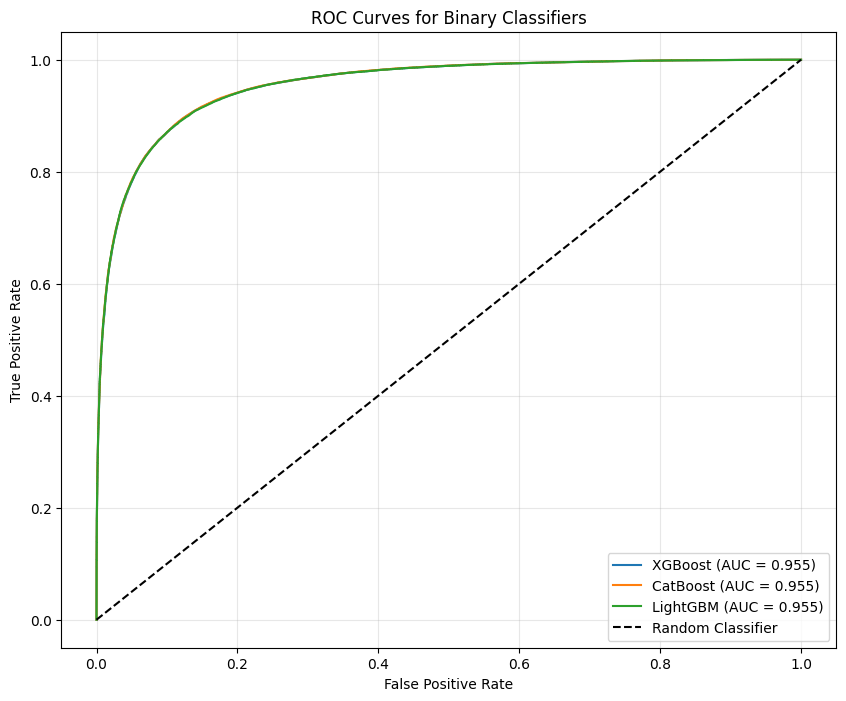

XGBoost log loss: 0.2679

XGBoost recall: 0.8690

XGBoost precision: 0.8815

CatBoost log loss: 0.2668

CatBoost recall: 0.8706

CatBoost precision: 0.8813

LightGBM log loss: 0.2680

LightGBM recall: 0.8690

LightGBM precision: 0.8805



In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, recall_score

plt.figure(figsize=(10, 8))

for name, clf in models.items():
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classifiers')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

for model, estimator in models.items():
    y_pred = estimator.predict(X_val)
    y_pred_proba = estimator.predict_proba(X_val)[:, 1]
    print(f'{model} log loss: {log_loss(y_val, y_pred_proba):.4f}\n')
    print(f'{model} recall: {recall_score(y_val, y_pred):.4f}\n')
    print(f'{model} precision: {precision_score(y_val, y_pred):.4f}\n')

In [8]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

model = CatBoostClassifier(iterations=1000, random_seed=42, verbose=0)
grid = {
    'learning_rate': [0.01, 0.03, 0.06],
    'depth': [3, 5, 6],
    'l2_leaf_reg': [1, 2, 3, 4],
    
}

grid_search_result = model.grid_search(grid, X_train, y_train, cv=3, verbose=False)

best_params = grid_search_result['params']


bestTest = 0.2716025521
bestIteration = 999


bestTest = 0.2677747593
bestIteration = 999


bestTest = 0.2662966953
bestIteration = 998


bestTest = 0.2716416274
bestIteration = 999


bestTest = 0.2678688425
bestIteration = 999


bestTest = 0.2662923064
bestIteration = 999


bestTest = 0.2716153013
bestIteration = 999


bestTest = 0.2677108778
bestIteration = 999


bestTest = 0.2662606929
bestIteration = 999


bestTest = 0.2716372666
bestIteration = 999


bestTest = 0.2679053482
bestIteration = 999


bestTest = 0.2662868541
bestIteration = 999


bestTest = 0.2693898766
bestIteration = 999


bestTest = 0.266454031
bestIteration = 999


bestTest = 0.2658655469
bestIteration = 968


bestTest = 0.2694227709
bestIteration = 999


bestTest = 0.2664752708
bestIteration = 999


bestTest = 0.2657925692
bestIteration = 995


bestTest = 0.2694190459
bestIteration = 999


bestTest = 0.2664474825
bestIteration = 999


bestTest = 0.2657931721
bestIteration = 990


bestTest = 0.2694221196
bestIterat

In [9]:
print("Best Parameters:", best_params)
best_model = CatBoostClassifier(**best_params, iterations=1000, random_seed=42, verbose=0)
best_model.fit(X_train, y_train)

Best Parameters: {'depth': 5, 'learning_rate': 0.06, 'l2_leaf_reg': 2}


In [10]:
test = pd.read_csv('data/lab5/test.csv')
id_df = test['id']
test.drop(columns=['id'], inplace=True)
pred = best_model.predict(test)

In [11]:
submission = pd.DataFrame({'id' : id_df, 'Heart Disease' : pred})
submission.to_csv('submission.csv', index=False)